# DT Assignment1

# Data Loading

In [1]:
import pandas as pd 
import numpy as np

In [2]:
pd_data = pd.read_csv('https://raw.githubusercontent.com/AugustLONG/ML01/master/01decisiontree/AllElectronics.csv')
pd_data.drop("RID",axis=1, inplace = True) #RID는 그냥 순서라서 삭제

In [3]:
pd_data.head()

,age,income,student,credit_rating,class_buys_computer
0,youth,high,no,fair,no
1,youth,high,no,excellent,no
2,middle_aged,high,no,fair,yes
3,senior,medium,no,fair,yes
4,senior,low,yes,fair,yes


In [4]:
pd_data.describe()

,age,income,student,credit_rating,class_buys_computer
count,14,14,14,14,14
unique,3,3,2,2,2
top,youth,medium,yes,fair,yes
freq,5,6,7,8,9


In [5]:
# 각 열당 몇개의 class로 되어있는지 확인한다.
pd_data.nunique()

age                    3
income                 3
student                2
credit_rating          2
class_buys_computer    2
dtype: int64

In [6]:
# 특정열의 클래스 개수를 세는방법
pd_data.class_buys_computer.value_counts()[0]

9

In [7]:
d = pd_data.class_buys_computer.value_counts()

In [8]:
type(d)  # 어떤형태로 저장되는지 궁금했다. 

pandas.core.series.Series

In [9]:
type(pd_data)

pandas.core.frame.DataFrame

In [10]:
len(pd.value_counts(pd_data.iloc[:,0].values))

3

In [11]:
# 첫번째 열의 unique 한 값들을 볼수있다.

pd.value_counts(pd_data.iloc[:,0].values)

youth          5
senior         5
middle_aged    4
dtype: int64

In [12]:
# 두번째 열의 unique 한 값들을 볼수있다.
pd.value_counts(pd_data.iloc[:,1].values)

medium    6
high      4
low       4
dtype: int64

# 1. Gini 계수를 구하는 함수 만들기

- Input: df(데이터), label(타겟변수명)
- 해당 결과는 아래와 같이 나와야 합니다.

In [13]:
pd_data['class_buys_computer'].value_counts(normalize=True)

yes    0.642857
no     0.357143
Name: class_buys_computer, dtype: float64

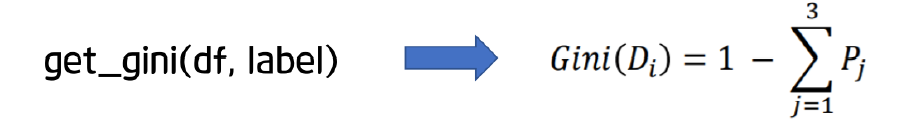

In [14]:
def get_gini(df, label):
    
    # 유일한 값별로 개수 세기 : value_counts()
    # normalize : False면 개수, True면 상대 비율 구함
    ratio = df[label].value_counts(normalize=True)
    gini = 1- ((ratio**2).sum())
    
    return gini

In [15]:
get_gini(pd_data,'class_buys_computer')

0.4591836734693877

# 2. Feature의 Class를 이진 분류로 만들기
 ## ex) {A,B,C} -> ({A}, {B,C}), ({B}, {A,C}), ({C}, {A,B})

- Input: df(데이터), attribute(Gini index를 구하고자 하는 변수명)
- 해당 결과는 아래와 같이 나와야 합니다.

In [16]:
pd_data["age"].value_counts().index

Index(['youth', 'senior', 'middle_aged'], dtype='object')

In [17]:
import itertools # 변수의 모든 클래시 조합을 얻기 위해 itertools 불러오기
from itertools import combinations  

def get_binary_split(df, attribute):
    
    result = []
    
    # 입력된 feature의 속성 개수가 4 면 0~4 까지 조합을 구해야 하니까 +1 을 해줌
    # 모든 경우의 조합을 다 구하고
    for i in range(len(df[attribute].value_counts())+1) :
        c=list(combinations(df[attribute].unique(),i))
        result = result+c
    
    return result[1:-1] # 조합중에서 첫번째와 마지막번째는 날려버린다~ 왜? nC0 과 nCn 은 필요없으니까 

In [18]:
get_binary_split(pd_data, "age")

[('youth',),
 ('middle_aged',),
 ('senior',),
 ('youth', 'middle_aged'),
 ('youth', 'senior'),
 ('middle_aged', 'senior')]

In [19]:
## 결과 형식을 바꾸기 위해 함수를 조금 변경했다.
## 리스트를 가져와서 다시한번 리스트를 씌워준다.

import itertools # 변수의 모든 클래시 조합을 얻기 위해 itertools 불러오기
from itertools import combinations

def get_binary_split(df, attribute):
    
    result = []
    for i in range(len(df[attribute].value_counts())+1) :
        # 조합을 뽑아낼건데, 유니크한 변수를 가지고 뽑아낼거다.
        c=(combinations(df[attribute].unique(),i))
        
        
        for k in c :
            result.append(list(k))
    
    return result[1:-1] 

In [20]:
get_binary_split(pd_data, "age")

[['youth'],
 ['middle_aged'],
 ['senior'],
 ['youth', 'middle_aged'],
 ['youth', 'senior'],
 ['middle_aged', 'senior']]

# 3. 다음은 모든 이진분류의 경우의 Gini index를 구하는 함수 만들기
- 위에서 완성한 두 함수를 사용하여 만들어주세요!
- 해당 결과는 아래와 같이 나와야 합니다.
- 결과로 나온 Dictionary의 Key 값은 해당 class 들로 이루어진 tuple 형태로 들어가 있습니다.

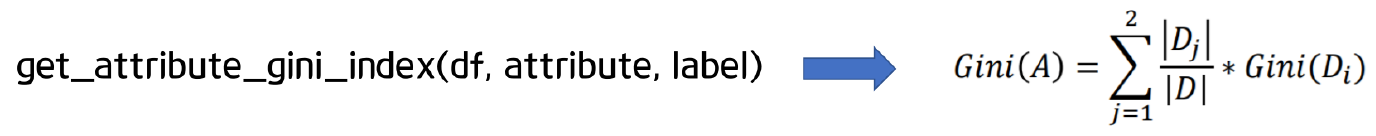

In [21]:
def get_attribute_gini_index(df, attribute, label):
    
    # n= 총 몇 열로 되어있는지
    n = len(df)
    result ={}
    
    for i in get_binary_split(df, attribute):
        
        # split 해서 나온 결과를 가지고 있는 애들을 true라고 하고,, true인 애들을 뽑아냄.
        df1 = df[df[attribute].apply(lambda x: x in i)]      # 원하는 애들이 있는거
        df2 = df[df[attribute].apply(lambda x: x not in i)]      # 원하는 애들이 없는거
        
        lenth = len(df1)
        v = (lenth/n)*get_gini(df1,label)+(1-(lenth/n))*get_gini(df2,label)
        
        result[tuple(i)] = v  
    
    return result

In [22]:
get_attribute_gini_index(pd_data, "age", "class_buys_computer")

{('youth',): 0.3936507936507936,
 ('middle_aged',): 0.35714285714285715,
 ('senior',): 0.4571428571428571,
 ('youth', 'middle_aged'): 0.4571428571428571,
 ('youth', 'senior'): 0.35714285714285715,
 ('middle_aged', 'senior'): 0.39365079365079364}

여기서 가장 작은 Gini index값을 가지는 class를 기준으로 split해야겠죠?

결과를 확인해보도록 하겠습니다.

어떤 변수가 가장 작은 gini index를 가지는지 모든 열에 대해서 알아보자.

In [23]:
my_dict = get_attribute_gini_index(pd_data, "age", "class_buys_computer")
key_min = min(my_dict.keys(), key=(lambda k: my_dict[k]))
print('Min -',key_min, ":", my_dict[key_min])

Min - ('middle_aged',) : 0.35714285714285715


In [24]:
my_dict = get_attribute_gini_index(pd_data, "income", "class_buys_computer")
key_min = min(my_dict.keys(), key=(lambda k: my_dict[k]))
print('Min -',key_min, ":", my_dict[key_min])

Min - ('high',) : 0.4428571428571429


In [25]:
my_dict = get_attribute_gini_index(pd_data, "student", "class_buys_computer")
key_min = min(my_dict.keys(), key=(lambda k: my_dict[k]))
print('Min -',key_min, ":", my_dict[key_min])

Min - ('no',) : 0.3673469387755103


In [26]:
my_dict = get_attribute_gini_index(pd_data, "credit_rating", "class_buys_computer")
key_min = min(my_dict.keys(), key=(lambda k: my_dict[k]))
print('Min -',key_min, ":", my_dict[key_min])

Min - ('excellent',) : 0.42857142857142855


# 다음의 문제를 위에서 작성한 함수를 통해 구한 값으로 보여주세요!
## 문제1) 변수 ‘income’의 이진분류 결과를 보여주세요.

## 문제2) 분류를 하는 데 가장 중요한 변수를 선정하고, 해당 변수의 Gini index를 제시해주세요.

## 문제3) 문제 2에서 제시한 feature로 DataFrame을 split한 후 나눠진 2개의 DataFrame에서 각각   다음으로 중요한 변수를 선정하고 해당 변수의 Gini index를 제시해주세요.

In [27]:
##문제1 답안
get_binary_split(pd_data, 'income')

[['high'],
 ['medium'],
 ['low'],
 ['high', 'medium'],
 ['high', 'low'],
 ['medium', 'low']]

In [28]:
##문제2 답안
## middle age 가 가장 작게 나왔다. (위에 25-28 line 참조)

my_dict = get_attribute_gini_index(pd_data, "age", "class_buys_computer")
key_min = min(my_dict.keys(), key=(lambda k: my_dict[k]))
print('Min -',key_min, ":", my_dict[key_min])

Min - ('middle_aged',) : 0.35714285714285715


In [30]:
##문제3 답안

## split 되었고, ( middle age 는 2번에서 선택되었으므로, 제외한다 )
df3 = pd_data[pd_data["age"].apply(lambda x: x not in "middle_aged")]
print(df3)

##
my_dict = get_attribute_gini_index(df3, "age", "class_buys_computer")
key_min = min(my_dict.keys(), key=(lambda k: my_dict[k]))
print('Min -',key_min, ":", my_dict[key_min])

my_dict = get_attribute_gini_index(df3, "income", "class_buys_computer")
key_min = min(my_dict.keys(), key=(lambda k: my_dict[k]))
print('Min -',key_min, ":", my_dict[key_min])

my_dict = get_attribute_gini_index(df3, "student", "class_buys_computer")
key_min = min(my_dict.keys(), key=(lambda k: my_dict[k]))
print('Min -',key_min, ":", my_dict[key_min])

my_dict = get_attribute_gini_index(df3, "credit_rating", "class_buys_computer")
key_min = min(my_dict.keys(), key=(lambda k: my_dict[k]))
print('Min -',key_min, ":", my_dict[key_min])

## 다음 튜플로 사용하면 좋은것은,,,  student 의 no이다.  

       age  income student credit_rating class_buys_computer
0    youth    high      no          fair                  no
1    youth    high      no     excellent                  no
3   senior  medium      no          fair                 yes
4   senior     low     yes          fair                 yes
5   senior     low     yes     excellent                  no
7    youth  medium      no          fair                  no
8    youth     low     yes          fair                 yes
9   senior  medium     yes          fair                 yes
10   youth  medium     yes     excellent                 yes
13  senior  medium      no     excellent                  no
Min - ('youth',) : 0.48
Min - ('high',) : 0.375
Min - ('no',) : 0.31999999999999984
Min - ('fair',) : 0.4166666666666667


다음 튜플로 사용하면 좋은것은,  student 의 no이다.  